In [30]:
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn.preprocessing

from tensorflow.keras import layers

In [31]:
print(tf.__version__)

2.5.0


In [32]:
path = r'../../../decipher/data2.csv'

In [33]:
batch_size = 2 ** 13
seed = 42

In [34]:
data = pd.read_csv(path)

In [35]:
data.columns=['source', 'key', 'converted']

In [36]:
data.head()

,source,key,converted
0,aa,1,bb
1,aa,2,cc
2,aa,3,dd
3,aa,4,ee
4,aa,5,ff


In [37]:
max_features = 1000
sequence_length = 10

In [38]:
vectorize_layer_converted = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

In [39]:
y_encoder = sklearn.preprocessing.LabelEncoder()

In [40]:
x = data['converted']
y = y_encoder.fit_transform(data['source'])

Make a text-only dataset (without labels), then call adapt

In [41]:
x.to_numpy(), y

(array(['bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk', 'll',
        'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt', 'uu', 'vv', 'ww',
        'xx', 'yy', 'zz', 'aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh',
        'ii', 'jj', 'kk', 'll', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss',
        'tt', 'uu', 'vv', 'ww', 'xx', 'yy', 'zz', 'aa', 'bb', 'cc', 'dd',
        'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk', 'll', 'mm', 'nn', 'oo',
        'pp', 'qq', 'rr', 'ss', 'tt', 'uu', 'vv', 'ww', 'xx', 'yy', 'zz',
        'aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk',
        'll', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt', 'uu', 'vv',
        'ww', 'aal', 'bbm', 'ccn', 'ddo', 'eep', 'ffq', 'ggr', 'hhs',
        'iit', 'jju', 'kkv', 'llw', 'mmx', 'nny', 'ooz', 'ppa', 'qqb',
        'rrc', 'ssd', 'tte', 'uuf', 'vvg', 'wwh', 'xxi', 'yyj', 'zzk',
        'aal', 'bbm', 'ccn', 'ddo', 'eep', 'ffq', 'ggr', 'hhs', 'iit',
        'jju', 'kkv', 'llw', 'mmx', 'nny', 'ooz', '

In [42]:
vectorize_layer_converted.adapt(x.to_numpy())

In [43]:
def vectorize_text(vectorize_layer, text):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)[0]

In [44]:
vectorize_text(vectorize_layer_converted, 'uwwilxuhn')

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)>

In [45]:
print(" 10 ---> ",vectorize_layer_converted.get_vocabulary()[10])
print("100 ---> ",vectorize_layer_converted.get_vocabulary()[100])
print('Vocabulary size: {}'.format(len(vectorize_layer_converted.get_vocabulary())))

 10 --->  vvg
100 --->  ddo
Vocabulary size: 132


In [46]:
classes_ = len(data['source'].unique())
print(f'Total classes {classes_}')

Total classes 5


In [47]:
x = np.asarray([vectorize_text(vectorize_layer_converted, i) for i in x])

# Load
# with open('x', 'rb') as file:
#     x = pickle.load(file)
#
# Save
# with open('x', 'wb') as file:
#     pickle.dump(x, file)

In [48]:
x

array([[111,   0,   0, ...,   0,   0,   0],
       [106,   0,   0, ...,   0,   0,   0],
       [101,   0,   0, ...,   0,   0,   0],
       ...,
       [ 12,   0,   0, ...,   0,   0,   0],
       [  7,   0,   0, ...,   0,   0,   0],
       [  2,   0,   0, ...,   0,   0,   0]], dtype=int64)

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, shuffle=True, random_state=seed, test_size=0.2,
)

In [51]:
embedding_dim = 16

In [52]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(sequence_length)),
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(classes_, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 16)            16016     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


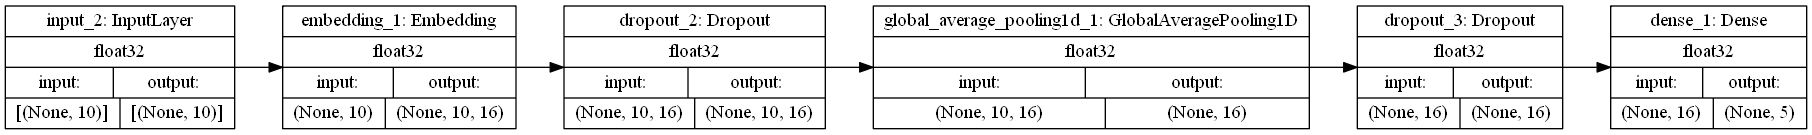

In [53]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True, show_dtype=True)

In [54]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.optimizers.Adam(),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)


In [55]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((403, 10), (403,), (101, 10), (101,))

In [56]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'model-class({classes_}).h5', monitor='val_sparse_categorical_accuracy',
    verbose=0, save_best_only=True, save_weights_only=True,
    mode='max', save_freq='epoch',
)

Some notes
```
250 epoch / 5 classes
```

In [57]:
history = model.fit(
    x_train, y_train, batch_size=batch_size,
    epochs=classes_ * 40, callbacks=[checkpoint], validation_data=(x_test, y_test),
)

Epoch 1/1250
1/1 [==============================] - 2s 2s/step - loss: 1.6077 - sparse_categorical_accuracy: 0.2233 - val_loss: 1.6146 - val_sparse_categorical_accuracy: 0.1188
Epoch 2/1250
1/1 [==============================] - 0s 25ms/step - loss: 1.6089 - sparse_categorical_accuracy: 0.2308 - val_loss: 1.6147 - val_sparse_categorical_accuracy: 0.1188
Epoch 3/1250
1/1 [==============================] - 0s 25ms/step - loss: 1.6070 - sparse_categorical_accuracy: 0.2258 - val_loss: 1.6149 - val_sparse_categorical_accuracy: 0.1188
Epoch 4/1250
1/1 [==============================] - 0s 27ms/step - loss: 1.6065 - sparse_categorical_accuracy: 0.2208 - val_loss: 1.6150 - val_sparse_categorical_accuracy: 0.1188
Epoch 5/1250
1/1 [==============================] - 0s 28ms/step - loss: 1.6072 - sparse_categorical_accuracy: 0.2333 - val_loss: 1.6152 - val_sparse_categorical_accuracy: 0.1188
Epoch 6/1250
1/1 [==============================] - 0s 36ms/step - loss: 1.6053 - sparse_categorical_accura

In [58]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('accuracy', round(acc, 2), 'loss', round(loss, 2))

1/1 [==============================] - 0s 15ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.9604
accuracy 0.96 loss 0.2


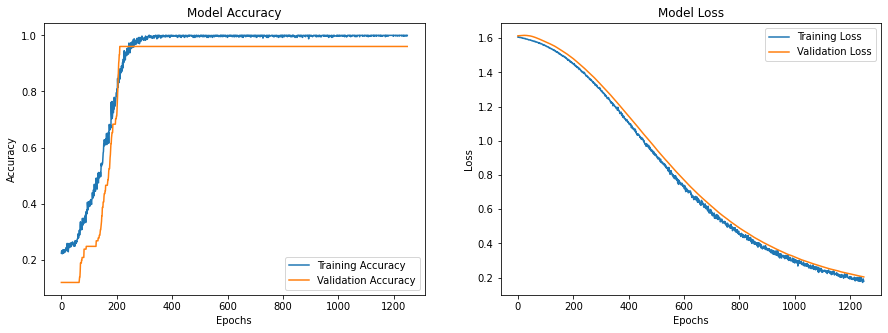

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()